# Considerations
In this tutorial i'll be talking about style transfer with TensorFlow. <br />
The algorithm is proposed by Gatys et al, on the paper [A Neural Algorithm Artistic Style](https://arxiv.org/abs/1508.06576) which were firstly proposed.

Any help, suggestions, or criticism will be very welcome! :D

**Obs** <br />
You'll away have to generate a new graph, if you want to change the images. <br />
It isn't the best way to implement this, but i guess that it'll be easier to understand.


# Style Transfer
Style transfer is an incredible technique that through convolutional neural networks (CNN) mixture the **style** of an image with the **content** of another image.

When we talk about **content**, we're referring to the lines that contour the image or the 'sketch' of them. <br />
The **style** would be the texture of the image.
<br />
<img src="images/01.png" />
<span style="font-size:11px;">Source: A Neural Algorithm Artistic Style<span>

The concept of style transfer is easy to understand. On the paper "A Neural Algorithm for Artistic Style", we have the following loss function that we should minimize.

$$
£_{total}(\vec{p}, \vec{a}, \vec{x})\ =\ \alpha \times £_{content}(\vec{p}, \vec{x})\ +\ \beta \times £_{style}(\vec{a}, \vec{x})
$$

On a first sight is scary, however it's easy to understand. <br />
* The $\vec{p}$, $\vec{a}$, $\vec{x}$ parameters are respectively the **content** image, the **style** image and the image that we are generating. <br />
* $\vec{p}$ and $\vec{a}$ are constants, and our goal is to find out the minimum argument $\vec{x}$ that minimizes the function $£_{total}(\vec{p}, \vec{a}, \vec{x})$.
* $£_{content}(\vec{p}, \vec{x})$ and $£_{style}(\vec{a}, \vec{x})$ are both loss function of the **content** and **style** image respectively.
* $\alpha$ and $\beta$ are weighting factors.

Now, let's import some dependencies and develop the loss function above in order to apply our style transfer.

In [14]:
# The VGG19 model the we'll be using
import vgg
# functions to handle images
from helper import load_image, plot_image
# to handle vectors/matrices
import numpy as np
# The TensorFlow library
import tensorflow as tf
# an optimizator
from tensorflow.contrib.opt import ScipyOptimizerInterface
#
import time
from os.path import isfile

The following code is just to check if you're using a GPU. <br />
If you're using a CPU, it might take much of your time to generate the image.

In [2]:
if not tf.test.is_gpu_available():
    print('No GPU available.', file=sys.stderr)
else:
    print('Default GPU: {}'.format(tf.test.gpu_device_name()))

Default GPU: /gpu:0


## About the VGG
Befre we apply the style transfer, let's talk about the VGG network. <br />
Our VGG model is already pretrained and it's available on the internet.

The VGG model is the one with 19 layers. Each layer contains a filter collection where each filter extract some image feature.

The model we're be using was designed to receive `inputs` rank 4 matrices `(batch, height, width, depth)` and there's a preprocessing before feedforward the network. <br />
Our images are rank 3, then we'll need to add another dimension and preprocess them. <br />

In [3]:
# Checking if the pretrained model does exist
assert isfile('imagenet-vgg-verydeep-19.mat'), 'The pretrained model should be on the project root'

In [4]:
# loading both the pretrained model and the RGB filters mean
# the filters are for preprocessing the images
vgg_weights, vgg_mean = vgg.load_net('imagenet-vgg-verydeep-19.mat')

## Loading the images
As we talked before, the content and style images we'll be constants. <br />
Let's load our images. <br /><br />

The content image will be my cat Mavis taking his incredible nap.

In [5]:
content_image = load_image('images/mavis.jpg', shape=(600, 336))
style_image   = load_image('images/style.jpg', shape=(content_image.shape[1], content_image.shape[0]))

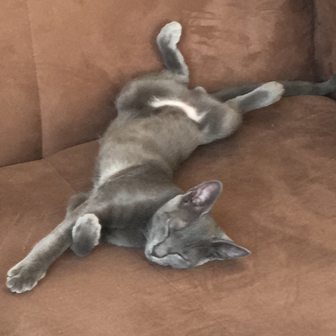

In [6]:
# just adjusting the image for plotting
img = plot_image(content_image)
img = img.rotate(270)
img.crop((132, 0, 468, 336))

The style image will be the [Eternal Winter III](https://aenea-jones.deviantart.com/art/Eternal-Winter-III-649588034) by Aenea-Jones that I found on [DeviantArt](https://www.deviantart.com/).

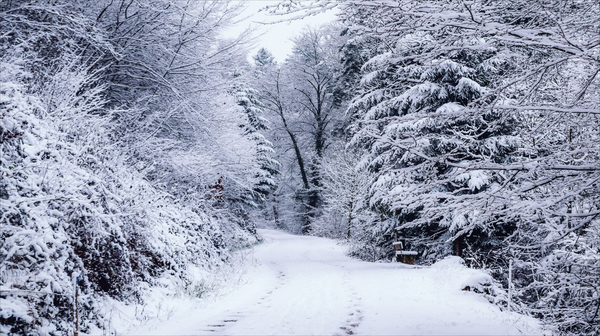

In [7]:
plot_image(style_image)

In [8]:
# adding another dimension on the images
content_image = content_image[None,:,:,:]
style_image = style_image[None,:,:,:]

# preprocessing them
content_image = vgg.preprocess(content_image, vgg_mean)
style_image = vgg.preprocess(style_image, vgg_mean)

print('Content Image Shape: {}'.format(content_image.shape))
print('Style Image Shape: {}'.format(style_image.shape))

Content Image Shape: (1, 336, 600, 3)
Style Image Shape: (1, 336, 600, 3)


## Defining the parameters
$\alpha$ and $\beta$ are weighting factors for the content and style reconstrution. <br />
On the papers, the writers used a ratio $\frac{\alpha}{\beta}$ equals to 1e-3 and 1e-4. <br />
Here we'll be using the ratio of 1e-3.


The content layer will be the `conv4_2` (we can add more layers). <br />
And the style layers will be `relu1_1`, `relu2_1`, `relu3_1`, `relu4_1` e `relu5_1`. <br />
The weighting factors mean how much each layer will contribute to the loss function.

In [31]:
# max amount of iteration
max_iter = 1000

# weighting factors
alpha = 1e-3
beta  = 1.

# content layers and their weights
content_layers  = ['conv4_2']
content_weights = [1.]

# style layers and their weights
style_layers  = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weights = np.ones([5]) * .2

## Building the content loss function
The content loss function is given by
$$£_{content}(\vec{p}, \vec{x}, l)\ =\ \frac{1}{2}\ \sum_{i,j} \big(F_{ij}^l - P_{ij}^l\big)^2$$


Here are some considerations:
* $l$ are the pretrained CNN layers.
* $P^l$ is the content feature representation ($\vec{p}$) on layer $l$.
* $F^l$ is the feature representation of the image that we're generating ($\vec{x}$) on layer $l$.

So, let's build the content loss function!

In [32]:
# the graph that we'll be working on
graph = tf.Graph()
with graph.as_default() as g:
    # as said before, p we'll be a constant
    p = tf.constant(content_image, tf.float32, name='p')
    # here we're feedforwarding the content image
    with g.name_scope('content'):
        vgg_content = vgg.net_preloaded(vgg_weights, p, 'max')
    
    # this we'll be the image that we're generating, so it'll be a variable
    # this is the variable that we're minimizing
    x = tf.get_variable('x', p.get_shape(), dtype=tf.float32, initializer=tf.random_uniform_initializer())
    with g.name_scope('mixture'):
        vgg_mixture = vgg.net_preloaded(vgg_weights, x, 'max')
    
    # content loss
    content_loss = 0
    for layer, weight in zip(content_layers, content_weights):
        P = vgg_content[layer] # getting the content feature representation
        F = vgg_mixture[layer] # getting the mixture feature representation
        content_loss += weight * .5 * tf.reduce_sum(tf.square(F-P))

The formula is translated on the last code line.
```python
(...) .5 * tf.reduce_sum(tf.square(F-P))
```

## Building the style loss function
Before we talk about the style loss, let's talk about the Gram matrix.

The matrix is given by
$$
G_{i,j}^l = \sum_k F_{ik}^lF_{jk}^l
$$


The Gram matrix is the inner product between the vectorised feature map. It's just the inner product between a matrix and its transpose. <br />
This matrix computes the correlations between the different filter responses.

In [33]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    num_channels = int(shape[3])
    
    matrix = tf.reshape(tensor, [-1, num_channels])

    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

The style loss function is given by
$$
£_{style}(\vec{a}, \vec{x})\ = \sum_{l=0}^L\ w_l \times \frac{1}{4 \times N_l^2 \times M_l^2} \sum_{i,j} \big(G_{ij}^l - A_{ij}^l\big)^2
$$
where:
* $w_l$ is the weighting factors for layer $l$. <br />
This was defined above and it means how much each layer will be contributing to the loss function. <br />
On this case, each layer will be contributing equally.
```python
style_weights = np.ones([5]) * .2
```
* $N$ is the amount of filters (depth) and each layer has size $M$ (height x width).
* $G^l$ and $A^l$ are the mixture and the style representations of the layer $l$. <br />
This one is similar to the content loss.

Let's build the style loss function!

In [34]:
with graph.as_default() as g:
    # the style image will be defined as constant too
    a = tf.constant(style_image, tf.float32, name='a')
    # and feedforwarding the style image
    with g.name_scope('style'):
        vgg_style = vgg.net_preloaded(vgg_weights, a, 'max')
    
    # style loss
    style_loss = 0
    for layer, weight in zip(style_layers, style_weights):
        _, h, w, d = vgg_mixture[layer].get_shape()
        M = h.value * w.value # size of the filters
        N = d.value           # amount the filters
        
        A = gram_matrix(vgg_style[layer])   # getting the style feature representation
        G = gram_matrix(vgg_mixture[layer]) # getting the mixture feature representation
        
        style_loss += weight * tf.reduce_sum(tf.square(G-A)) * ((1.)/(4. * N**2 * M**2))

And again our formula is translated on the last code line.
## Building the optimizer
As said before, our goal is to minimize the function

$$
£_{total}(\vec{p}, \vec{a}, \vec{x})\ =\ \alpha \times £_{content}(\vec{p}, \vec{x})\ +\ \beta \times £_{style}(\vec{a}, \vec{x})
$$

here, we'll be jointly minimizing the distance of the mixture image from content representation and the style representation in layers of the CNN.

In [35]:
with graph.as_default() as g:
    # total loss
    total_loss = alpha*content_loss + beta*style_loss
    
    # optimizer
    optimizer = ScipyOptimizerInterface(total_loss, method='L-BFGS-B', options={'maxiter': max_iter})

## Running the graph!
Now we can run our style transfer graph. <br />
I ran the graph on my GPU GeForce 930M 4GB, 1000 iterations last approximately 22 minutes. <br />
If you want to see immediately the results, with 100 iterations should be enough. <br />
However, the results are better with 500-2000 iterations.

Before we run it, let's build a function to give us some feedback while it runs. <br />

In [1]:
call_iter = 0
results = {}

def call_back(x):
    global call_iter
    global results
    
    if call_iter % 10 == 0:
        print('\riter: {}'.format(call_iter), end='')
    
    if call_iter % 10 == 0 and call_iter <= 100:
        results[call_iter] = x
    
    call_iter +=1

In [39]:
start = time.time()
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimizer.minimize(sess, fetches=[x], loss_callback=call_back)
    
    output = sess.run(x)
print('Elapsed time: {}'.format(time.time() - start))

iter: 1020INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1052765632.000000
  Number of iterations: 1001
  Number of functions evaluations: 1024
Elapsed time: 1352.0401647090912


Before we plot the final result, let's undo the preprocessing.

In [160]:
final = vgg.unprocess(output, vgg_mean)
img = plot_image(np.clip(final, 0, 255)[0])

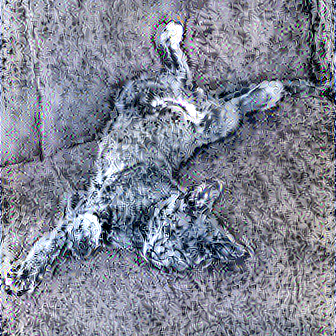

In [184]:
# result after 1000 iterations
img = img.rotate(270).crop((132, 0, 468, 336))
img

We saved the first 10 images (result of the first 100 iteration mod 10). <br />
Let's see how the image developed along the 100 iterations...

In [92]:
from PIL import Image

In [162]:
keys = results.keys()
keys = list(keys)
keys = sorted(keys)
keys = keys[1:]

In [186]:
new_im = Image.new('RGB', (img.size[1] * 5, img.size[0] * 2))
i = 0
for col in range(2):
    for row in range(5):
        key = keys[i]
        
        image = vgg.unprocess(results[key], vgg_mean)
        image = plot_image(np.clip(image, 0, 255)[0])
        
        image = image.rotate(270)
        image = image.crop((132, 0, 468, 336))

        new_im.paste(image, (row * image.size[1], col * image.size[0]))
        cols += final.shape[1]
        i += 1

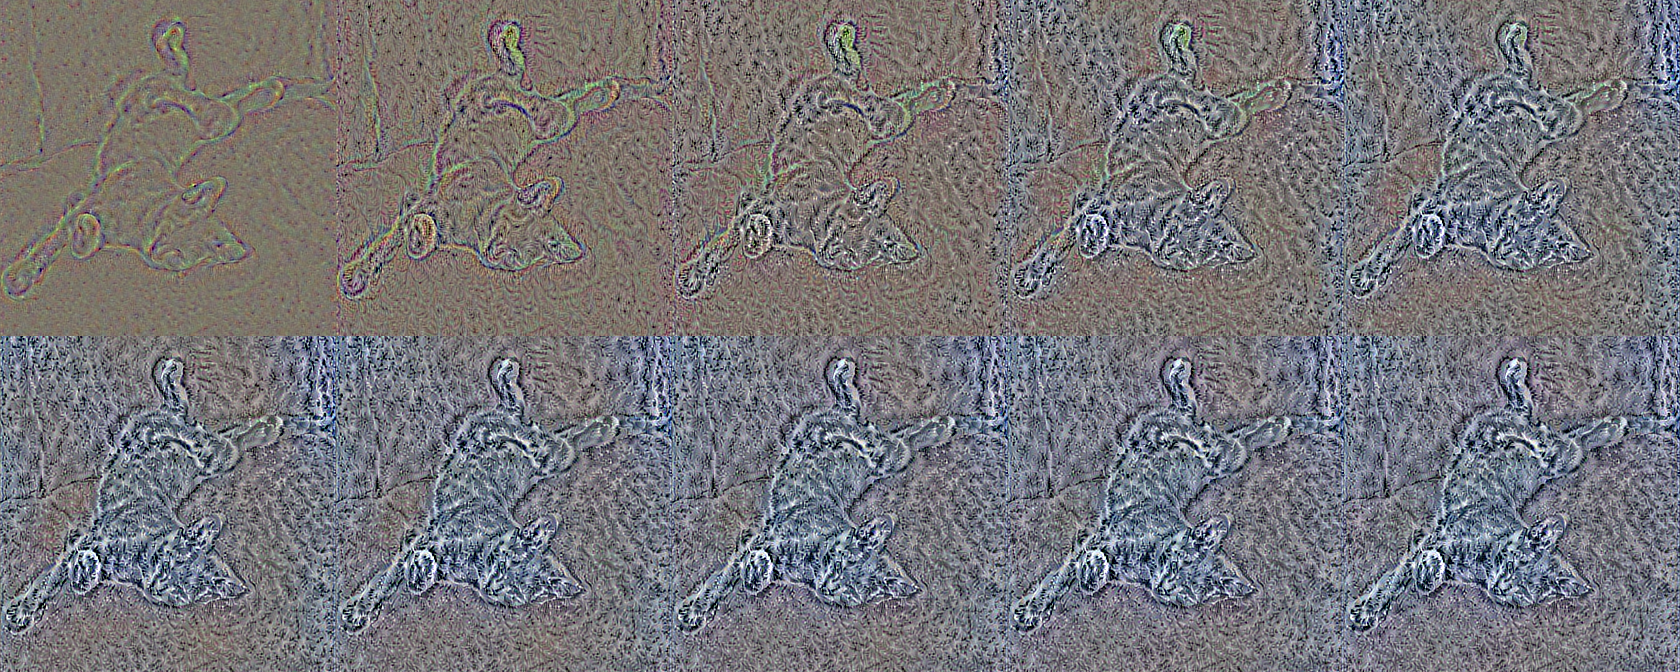

In [187]:
new_im